In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline 

import math

In [2]:
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i, pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5

#Source: https://www.kaggle.com/marknagelberg/rmsle-function

In [3]:
#LOAD DATA
train = pd.read_table("train.tsv")
test = pd.read_table("test.tsv")
print(train.shape)
print(test.shape)

(1482535, 8)
(693359, 7)


In [4]:
#HANDLE MISSING VALUES
def handle_missing(dataset):
    dataset.category_name.fillna(value="_LEFTBLANK_", inplace=True)
    dataset.brand_name.fillna(value="_LEFTBLANK_", inplace=True)
    dataset.item_description.fillna(value="_LEFTBLANK_", inplace=True)
    return dataset

train = handle_missing(train)
test = handle_missing(test)

In [5]:
# Split (sub)categories into separate columns 
cats = train['category_name'].str.split('/', expand=True) #can also add n=3
cats.columns = ['category_' + str(i) for i in cats.columns]
del train['category_name']

# Add to original dataframe
train = pd.concat([train, cats], axis=1)

## TEST DATA
# Split (sub)categories into separate columns 
cats = test['category_name'].str.split('/', expand=True) #can also add n=3
cats.columns = ['category_' + str(i) for i in cats.columns]
del test['category_name']

# Add to original dataframe
test = pd.concat([test, cats], axis=1)


train.head(1)

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,category_0,category_1,category_2,category_3,category_4
0,0,MLB Cincinnati Reds T Shirt Size XL,3,_LEFTBLANK_,10.0,1,No description yet,Men,Tops,T-shirts,None,None


In [6]:
#PROCESS CATEGORICAL DATA

for i in ['category_0', 'category_1', 'category_2', 'category_3', 'category_4']:
    train[i] = train[i].fillna('_NONE_')
    test[i] = test[i].fillna('_NONE_')
    labeler = LabelEncoder()
    labeler.fit(np.hstack([train[i], test[i]]))

    train['category_' + str(i[-1]) + '_name'] = labeler.transform(train[i])
    test['category_' + str(i[-1]) + '_name'] = labeler.transform(test[i])

In [7]:
labeler.fit(np.hstack([train.brand_name, test.brand_name]))

train.brand_name = labeler.transform(train.brand_name)
test.brand_name = labeler.transform(test.brand_name)

train.head(3)

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,category_0,category_1,category_2,category_3,category_4,category_0_name,category_1_name,category_2_name,category_3_name,category_4_name
0,0,MLB Cincinnati Reds T Shirt Size XL,3,5204,10.0,1,No description yet,Men,Tops,T-shirts,_NONE_,_NONE_,5,102,773,6,0
1,1,Razer BlackWidow Chroma Keyboard,3,3889,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,_NONE_,_NONE_,1,30,215,6,0
2,2,AVA-VIV Blouse,1,4588,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,_NONE_,_NONE_,9,103,97,6,0


In [8]:
#PROCESS RAW TEXT
from keras.preprocessing.text import Tokenizer

print("Text to seq process...")
raw_text = np.hstack([train.item_description.str.lower(), train.name.str.lower()])

print("Fitting tokenizer...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(raw_text)

print("Transforming text to seq...")
train["seq_item_description"] = tokenizer.texts_to_sequences(train.item_description.str.lower())
test["seq_item_description"] = tokenizer.texts_to_sequences(test.item_description.str.lower())
train["seq_name"] = tokenizer.texts_to_sequences(train.name.str.lower())
test["seq_name"] = tokenizer.texts_to_sequences(test.name.str.lower())

train.head(3)

C:\Users\Vince\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Text to seq process...
Fitting tokenizer...
Transforming text to seq...


,train_id,name,item_condition_id,brand_name,price,shipping,item_description,category_0,category_1,category_2,category_3,category_4,category_0_name,category_1_name,category_2_name,category_3_name,category_4_name,seq_item_description,seq_name
0,0,MLB Cincinnati Reds T Shirt Size XL,3,5204,10.0,1,No description yet,Men,Tops,T-shirts,_NONE_,_NONE_,5,102,773,6,0,"[12, 68, 79]","[3852, 8823, 6896, 208, 84, 6, 155]"
1,1,Razer BlackWidow Chroma Keyboard,3,3889,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,_NONE_,_NONE_,1,30,215,6,0,"[29, 2627, 10, 7, 39, 17, 1, 207, 51, 19, 1113...","[10760, 25565, 16369, 2627]"
2,2,AVA-VIV Blouse,1,4588,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,_NONE_,_NONE_,9,103,97,6,0,"[604, 60, 9, 4, 5347, 11, 192, 1, 4, 886, 1290...","[7634, 10563, 666]"


In [9]:
#SEQUENCES VARIABLES ANALYSIS
itemnames = np.hstack([train.seq_name, test.seq_name])
itemnames_len = pd.Series(itemnames).apply(len)
print("max name seq:", itemnames_len.max())

itemdescs = np.hstack([train.seq_item_description, test.seq_item_description])
itemdescs_len = pd.Series(itemdescs).apply(len)
print("max item desc seq", itemdescs_len.max())

max name seq: 17
max item desc seq 269


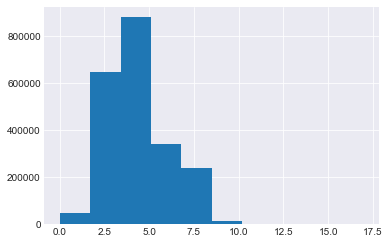

In [10]:
itemnames_len.hist()

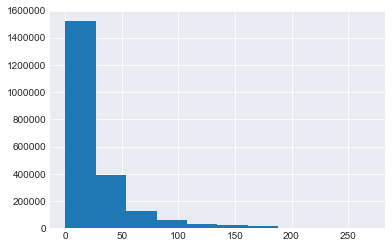

In [11]:
itemdescs_len.hist()

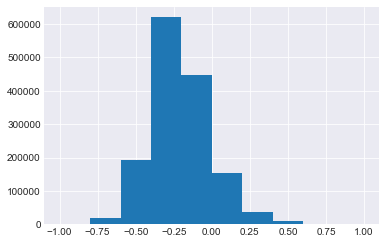

In [12]:
# Scale target variable
train["target"] = np.log1p(train.price)
target_scaler = MinMaxScaler(feature_range=(-1, 1))

train["target"] = target_scaler.fit_transform(train["target"].values.reshape(-1,1))
train.target.hist()

In [13]:
# CREATE VALIDATION DATA
dtrain, dval = train_test_split(train, random_state=100, test_size=0.01)

print(dtrain.shape)
print(dval.shape)

(1467709, 20)
(14826, 20)


In [14]:
#EMBEDDINGS MAX VALUE
#Base on the histograms, we select the next lengths

MAX_NAME_SEQ = 12
MAX_ITEM_DESC_SEQ = 200

MAX_TOKEN = len(tokenizer.word_index) + 1
# 259089

MAX_CATEGORY0 = np.max([train.category_0_name.max(), test.category_0_name.max()]) + 1
MAX_CATEGORY1 = np.max([train.category_1_name.max(), test.category_1_name.max()]) + 1
MAX_CATEGORY2 = np.max([train.category_2_name.max(), test.category_2_name.max()]) + 1
MAX_CATEGORY3 = np.max([train.category_3_name.max(), test.category_3_name.max()]) + 1
MAX_CATEGORY4 = np.max([train.category_4_name.max(), test.category_4_name.max()]) + 1

MAX_BRAND = np.max([train.brand_name.max(), test.brand_name.max()]) + 1
# 5290

MAX_CONDITION = np.max([train.item_condition_id.max(), test.item_condition_id.max()]) + 1
# 6

dtrain and dval are training and validation dataframes. They both have x and y values, but we separate the x's in the next step.

In [15]:
# KERAS DATA DEFINITION
from keras.preprocessing.sequence import pad_sequences

def get_keras_data(dataset):
    X = {
        'name': pad_sequences(dataset.seq_name, maxlen=MAX_NAME_SEQ),
        'item_desc': pad_sequences(dataset.seq_item_description, maxlen=MAX_ITEM_DESC_SEQ),
        'brand_name': np.array(dataset.brand_name),
        'category_0_name': np.array(dataset.category_0_name),
        'category_1_name': np.array(dataset.category_1_name),
        'category_2_name': np.array(dataset.category_2_name),
        'category_3_name': np.array(dataset.category_3_name),
        'category_4_name': np.array(dataset.category_4_name),
        'item_condition' : np.array(dataset.item_condition_id),
        'shipping'       : np.array(dataset.shipping)
    }
    return X

# X
X_train = get_keras_data(dtrain)
X_val = get_keras_data(dval)

X_test = get_keras_data(test)

# Y
y_train = dtrain['target']
y_val = dval['target']
y_true = dval['price'] # So we can judge our validation score meaningfully

# RNN

In [16]:
#KERAS MODEL DEFINITION
from keras.layers import (Input, Dropout, Dense, BatchNormalization, Activation,
                          concatenate, LSTM, Embedding, Flatten, BatchNormalization)
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import backend as K

def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

def rmsle_cust(y_true, y_pred):
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1))

def get_model_rnn():
    #params
    dropout_rate = 0.1
    
    #Inputs
    name           = Input(shape=[MAX_NAME_SEQ], name="name")
    item_desc      = Input(shape=[MAX_ITEM_DESC_SEQ], name="item_desc")
    brand_name     = Input(shape=[1], name="brand_name")
    category_0_name  = Input(shape=[1], name="category_0_name")
    category_1_name  = Input(shape=[1], name="category_1_name")
    category_2_name  = Input(shape=[1], name="category_2_name")
    category_3_name  = Input(shape=[1], name="category_3_name")
    category_4_name  = Input(shape=[1], name="category_4_name")
    item_condition = Input(shape=[1], name="item_condition")
    shipping       = Input(shape=[1], name="shipping")
    
    #Embedding layers
    emb_name            = Embedding(MAX_TOKEN, 100)(name)
    emb_item_desc       = Embedding(MAX_TOKEN, 100)(item_desc)
    emb_brand_name      = Embedding(MAX_BRAND, 50)(brand_name)
    emb_category_0_name = Embedding(MAX_CATEGORY0, 30)(category_0_name)
    emb_category_1_name = Embedding(MAX_CATEGORY1, 30)(category_1_name)
    emb_category_2_name = Embedding(MAX_CATEGORY2, 30)(category_2_name)
    emb_category_3_name = Embedding(MAX_CATEGORY3, 30)(category_3_name)
    emb_category_4_name = Embedding(MAX_CATEGORY4, 30)(category_4_name)
    emb_item_condition  = Embedding(MAX_CONDITION, MAX_CONDITION)(item_condition)
    emb_shipping        = Embedding(2, 2)(shipping)
    # [100, 100, 50, 30...] are the lengths of the embedding vectors.
    # This is a hyperparameter you can optimize.
    
    #rnn layer
    rnn_layer1 = LSTM(16)(emb_item_desc)
    rnn_layer2 = LSTM(8)(emb_name)
    
    #main layer
    main_layer = concatenate([
        Flatten() (emb_brand_name),
        Flatten() (emb_category_0_name),
        Flatten() (emb_category_1_name),
        Flatten() (emb_category_2_name),
        Flatten() (emb_category_3_name),
        Flatten() (emb_category_4_name),
        Flatten() (emb_item_condition),
        rnn_layer1,
        rnn_layer2,
        Flatten() (emb_shipping)
    ])
    main_layer = Dropout(dropout_rate) (Dense(128) (main_layer))
    main_layer = Dropout(dropout_rate) (Dense(64) (main_layer))
    
    #output
    output = Dense(1, activation="linear") (main_layer)
    
    #model
    model = Model([name,
                   item_desc,
                   brand_name,
                   category_0_name,
                   category_1_name,
                   category_2_name,
                   category_3_name,
                   category_4_name,
                   item_condition,
                   shipping],
                  output)
    model.compile(loss="mse", optimizer="adam", metrics=["mae", rmsle_cust])
    
    return model

    
model = get_model_rnn()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
brand_name (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
category_0_name (InputLayer)    (None, 1)            0                                            
__________________________________________________________________________________________________
category_1_name (InputLayer)    (None, 1)            0                                            
__________________________________________________________________________________________________
category_2_name (InputLayer)    (None, 1)            0                                            
__________________________________________________________________________________________________
category_3

`emb_name = Embedding(MAX_TOKEN, 50)(name)`

Recall that `MAX_TOKEN` is the length of the word index. Technically, you can make this embedding bigger than that, but there's no reason to. You can't, however, make it smaller.

In [17]:
#FITTING THE MODEL
BATCH_SIZE = 1024
epochs = 4

es = EarlyStopping(patience=1)

model = get_model_rnn()
model.fit(X_train, y_train, epochs=epochs, batch_size=BATCH_SIZE,
          validation_data=(X_val, y_val), verbose=1, callbacks=[es])

Train on 1467709 samples, validate on 14826 samples
Epoch 1/10
1467709/1467709 [==============================] - 1399s 953us/step - loss: 0.0168 - mean_absolute_error: 0.0976 - rmsle_cust: 0.0128 - val_loss: 0.0150 - val_mean_absolute_error: 0.0916 - val_rmsle_cust: 0.0120

In [18]:
# EVALUATE THE MODEL ON VALIDATION DATA: What is it doing?
y_pred = model.predict(X_val)
y_pred = target_scaler.inverse_transform(y_pred)
y_pred = np.expm1(y_pred)
y_pred = y_pred.flatten()
# .45612396047660847
# mean_squared_log_error
v_rmsle = rmsle(y_true.values, y_pred)
print("RMSLE on validation data:", v_rmsle)

RMSLE on validation data: 0.4508328299229967


In [19]:
from sklearn.metrics import mean_absolute_error
# 9.761177553365737
v_mae = mean_absolute_error(y_true.values, y_pred)
print("MAE on validation data:", v_mae)

MAE on validation data: 9.699915408975567


In [20]:
from sklearn.metrics import r2_score
# 0.5425363571573779
r2 = r2_score(y_true.values, y_pred)
print("R2 on validation data:", r2)

R2 on validation data: 0.5527194198613601


# CNN

In [19]:
#KERAS MODEL DEFINITION
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPool1D
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

#KERAS MODEL DEFINITION
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import backend as K


def rmsle_cust(y_true, y_pred):
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1))

def get_model_cnn():
    #params
    dropout_rate = 0.1
    
    #Inputs
    name             = Input(shape=[MAX_NAME_SEQ], name="name")
    item_desc        = Input(shape=[MAX_ITEM_DESC_SEQ], name="item_desc")
    brand_name       = Input(shape=[1], name="brand_name")
    category_0_name  = Input(shape=[1], name="category_0_name")
    category_1_name  = Input(shape=[1], name="category_1_name")
    category_2_name  = Input(shape=[1], name="category_2_name")
    category_3_name  = Input(shape=[1], name="category_3_name")
    category_4_name  = Input(shape=[1], name="category_4_name")
    item_condition   = Input(shape=[1], name="item_condition")
    shipping         = Input(shape=[1], name="shipping")
    
    #Embedding layers
    emb_name            = Embedding(MAX_TOKEN, 100)(name)
    emb_item_desc       = Embedding(MAX_TOKEN, 100)(item_desc)
    emb_brand_name      = Embedding(MAX_BRAND, 50)(brand_name)
    emb_category_0_name = Embedding(MAX_CATEGORY0, 30)(category_0_name)
    emb_category_1_name = Embedding(MAX_CATEGORY1, 30)(category_1_name)
    emb_category_2_name = Embedding(MAX_CATEGORY2, 30)(category_2_name)
    emb_category_3_name = Embedding(MAX_CATEGORY3, 30)(category_3_name)
    emb_category_4_name = Embedding(MAX_CATEGORY4, 30)(category_4_name)
    emb_item_condition  = Embedding(MAX_CONDITION, MAX_CONDITION)(item_condition)
    emb_shipping        = Embedding(2, 2)(shipping)
    
    #cnn layer
    cnn_layer1 = Conv1D(filters=64, kernel_size=3, padding='valid',
                        activation='relu', strides=1) (emb_item_desc)
    cnn_layer1 = MaxPool1D() (cnn_layer1)
    
    cnn_layer2 = Conv1D(filters=64, kernel_size=3, padding='valid',
                        activation='relu', strides=1) (emb_name)
    cnn_layer2 = MaxPool1D() (cnn_layer2)
    
    #main layer
    main_layer = concatenate([
        Flatten() (emb_brand_name),
        Flatten() (emb_category_0_name),
        Flatten() (emb_category_1_name),
        Flatten() (emb_category_2_name),
        Flatten() (emb_category_3_name),
        Flatten() (emb_category_4_name),
        Flatten() (emb_item_condition),
        Flatten() (cnn_layer1),
        Flatten() (cnn_layer2),
        Flatten() (emb_shipping)
    ])
    main_layer = Dropout(dropout_rate) (Dense(128) (main_layer))
    main_layer = Dropout(dropout_rate) (Dense(64) (main_layer))
    
    #output
    output = Dense(1, activation="linear") (main_layer)
    
    #model
    model = Model([name,
                   item_desc,
                   brand_name,
                   category_0_name,
                   category_1_name,
                   category_2_name,
                   category_3_name,
                   category_4_name,
                   item_condition,
                   shipping],
                  output)
    
    model.compile(loss="mse", optimizer="adam", metrics=["mae", rmsle_cust])
    
    return model

    
model = get_model_cnn()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
item_desc (InputLayer)          (None, 200)          0                                            
__________________________________________________________________________________________________
name (InputLayer)               (None, 12)           0                                            
__________________________________________________________________________________________________
embedding_32 (Embedding)        (None, 200, 100)     25908900    item_desc[0][0]                  
__________________________________________________________________________________________________
embedding_31 (Embedding)        (None, 12, 100)      25908900    name[0][0]                       
__________________________________________________________________________________________________
brand_name

In [21]:
#FITTING THE MODEL
BATCH_SIZE = 1024
epochs = 10
es = EarlyStopping()
model.fit(X_train, y_train, epochs=epochs, batch_size=BATCH_SIZE,
          validation_data=(X_val, y_val), verbose=1, callbacks=[es])

Train on 1467709 samples, validate on 14826 samples
Epoch 1/10
1467709/1467709 [==============================] - 247s 169us/step - loss: 0.0160 - mean_absolute_error: 0.0952 - rmsle_cust: 0.0126 - val_loss: 0.0144 - val_mean_absolute_error: 0.0896 - val_rmsle_cust: 0.0118

In [22]:
# EVALUATE THE MODEL ON VALIDATION DATA: What is it doing?
y_pred = model.predict(X_val)
y_pred = target_scaler.inverse_transform(y_pred)
y_pred = np.expm1(y_pred)
y_pred = y_pred.flatten()

# mean_squared_log_error
v_rmsle = rmsle(y_true.values, y_pred)
print("RMSLE on validation data:", v_rmsle)

RMSLE on validation data: 0.45841541161732735


In [23]:
from sklearn.metrics import mean_absolute_error

v_mae = mean_absolute_error(y_true.values, y_pred)
print("MAE on validation data:", v_mae)

MAE on validation data: 9.872435680336915


In [24]:
from sklearn.metrics import r2_score

r2 = r2_score(y_true.values, y_pred)
print("R2 on validation data:", r2)

R2 on validation data: 0.5249282323734537


C:\Users\vince\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


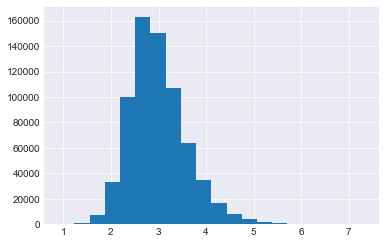

In [25]:
# #CREATE PREDICTIONS
preds = model.predict(X_test, batch_size=BATCH_SIZE)
preds = target_scaler.inverse_transform(preds)
preds = np.expm1(preds)

submission = test[["test_id"]]
submission["price"] = preds

submission.to_csv("submission.csv", index=False)
pd.Series(np.log1p(submission.price)).hist(bins=20)